In [1]:
#ARIMA 
#models doesnt work well with stocks

In [2]:
#     Visualize the Time Series Data
#     Make the time series data stationary
#     Plot the Correlation and AutoCorrelation Charts
#     Construct the ARIMA Model
#     Use the model to make predictions

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [4]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [5]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [6]:
df.columns = ['Month','Milk in Pounds per Cow']

In [7]:
df.tail()

,Month,Milk in Pounds per Cow
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [8]:
df.drop(168,axis=0, inplace=True)

In [9]:
df.tail()

,Month,Milk in Pounds per Cow
163,1975-08,858.0
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0


In [10]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

In [11]:
df.head()

,Milk in Pounds per Cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in Pounds per Cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


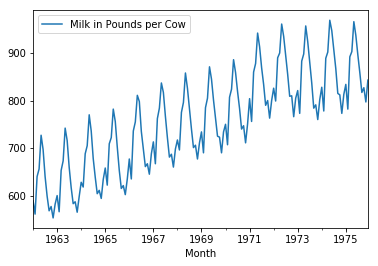

In [13]:
#Visualize the data
df.plot()

In [14]:
time_series = df['Milk in Pounds per Cow']

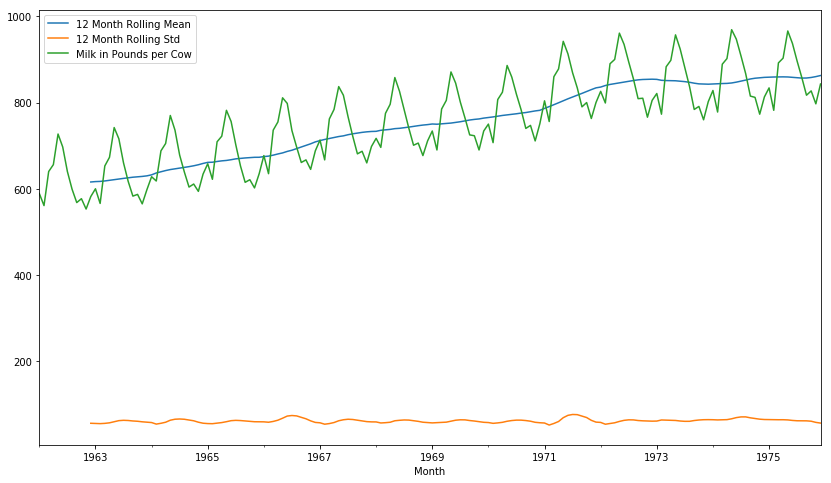

In [15]:
plt.figure(figsize=(14,8))
time_series.rolling(12).mean().plot(label='12 Month Rolling Mean')
time_series.rolling(12).std().plot(label='12 Month Rolling Std')
time_series.plot()
plt.legend()

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
decomp = seasonal_decompose(time_series)

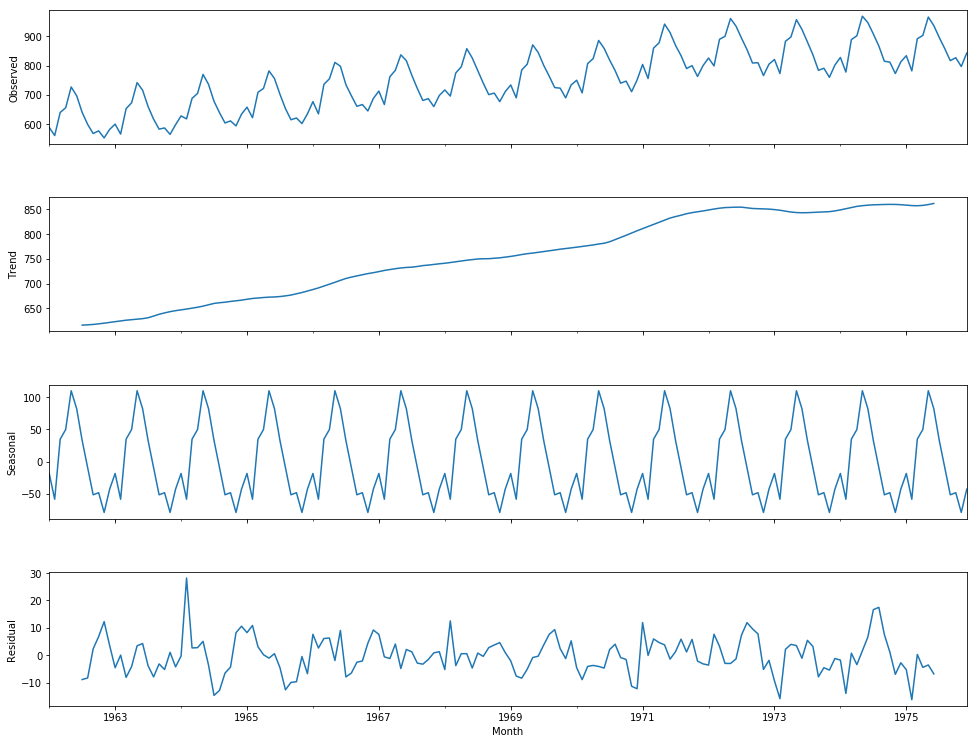

In [18]:
fig = decomp.plot()
fig.set_size_inches(15,12)

In [19]:
#Make the time series data stationary
#dickey-fuller test
from statsmodels.tsa.stattools import adfuller

In [20]:
# result = adfuller(df['Milk in Pounds per Cow'])

In [21]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [22]:
adf_check(df['Milk in Pounds per Cow'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.3038115874221294
p-value : 0.6274267086030316
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [23]:
df['First Difference'] = df['Milk in Pounds per Cow'] - df['Milk in Pounds per Cow'].shift(1)

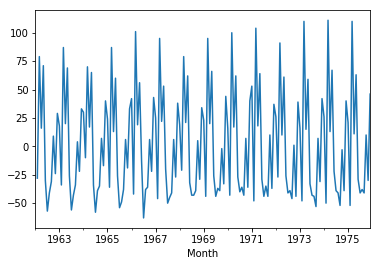

In [24]:
df['First Difference'].plot()

In [25]:
adf_check(df['First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.0549955586530704
p-value : 0.030068004001785647
#Lags Used : 14
Number of Observations Used : 152
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


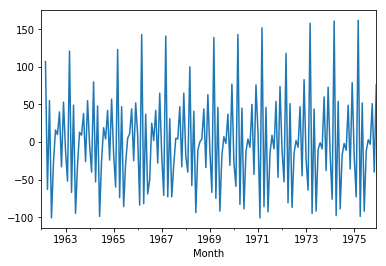

In [26]:
df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)
df['Second Difference'].plot()

In [27]:
adf_check(df['Second Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -14.327873645603301
p-value : 1.1126989332084581e-26
#Lags Used : 11
Number of Observations Used : 154
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


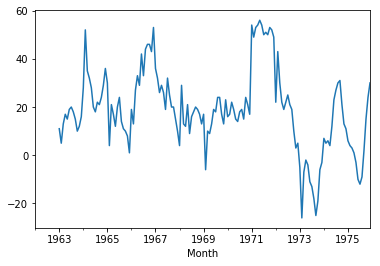

In [28]:
df['Seasonal Difference'] = df['Milk in Pounds per Cow'] - df['Milk in Pounds per Cow'].shift(12)
df['Seasonal Difference'].plot()

In [29]:
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.335419314359398
p-value : 0.1607988052771135
#Lags Used : 12
Number of Observations Used : 143
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


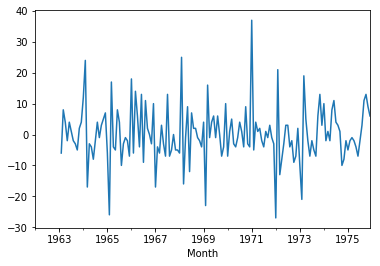

In [69]:
df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(12)
df['Seasonal First Difference'].plot()

In [70]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.038002274921984
p-value : 1.8654234318788342e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [71]:
#     Plot the Correlation and AutoCorrelation Charts

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

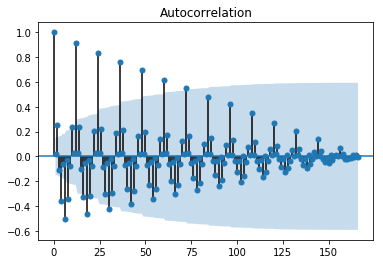

In [73]:
fig_first = plot_acf(df['First Difference'].dropna())

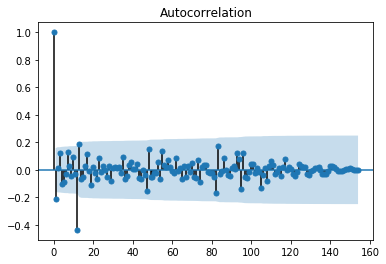

In [74]:
fig_seasonal_first = plot_acf(df['Seasonal First Difference'].dropna())

In [75]:
#with pandas
from pandas.plotting import autocorrelation_plot

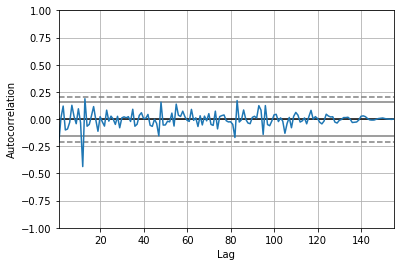

In [76]:
autocorrelation_plot(df['Seasonal First Difference'].dropna())

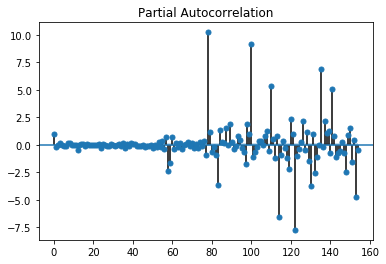

In [77]:
partial_auto = plot_pacf(df['Seasonal First Difference'].dropna())

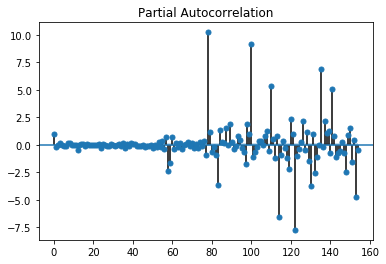

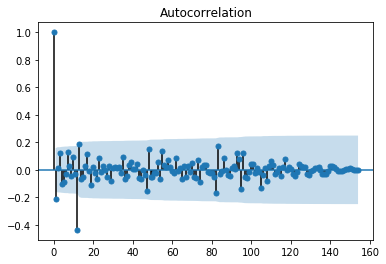

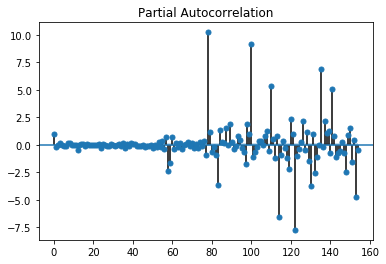

In [78]:
plot_acf(df['Seasonal First Difference'].dropna())
plot_pacf(df['Seasonal First Difference'].dropna())

In [79]:
from statsmodels.tsa.arima_model import ARIMA

In [80]:
model = sm.tsa.statespace.SARIMAX(df['Milk in Pounds per Cow'],order=(0,1,0),seasonal_order=(1,1,1,12))

C:\Users\gsg18\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [81]:
results = model.fit()

In [82]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:             Milk in Pounds per Cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Mon, 02 Sep 2019   AIC                           1074.131
Time:                                    09:46:55   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

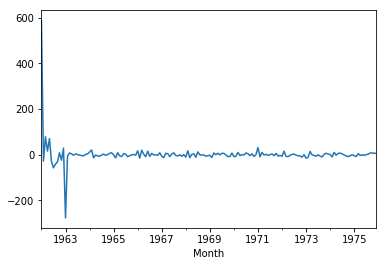

In [83]:
results.resid.plot()

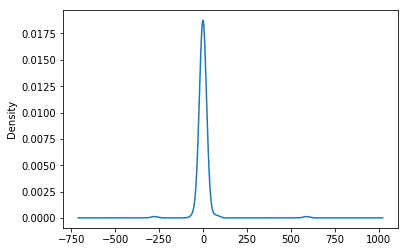

In [84]:
results.resid.plot(kind='kde')

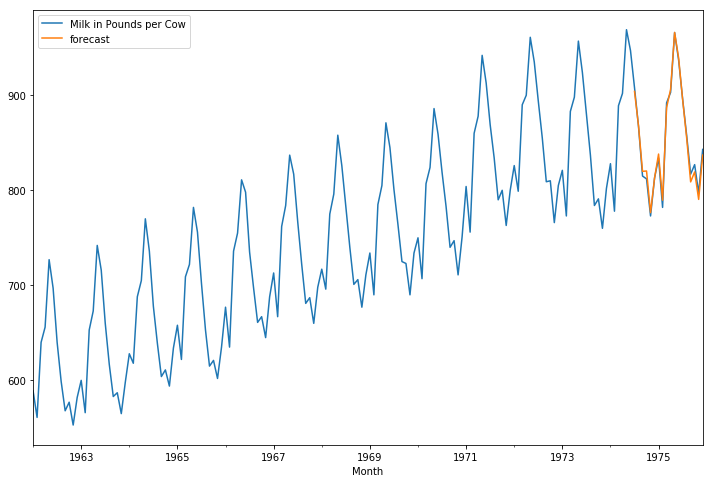

In [85]:
df['forecast'] = results.predict(start=150, end=168)
df[['Milk in Pounds per Cow','forecast']].plot(figsize=(12,8))

In [86]:
df.tail()

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
Month,,,,,,
1975-08-01,858.0,-38.0,3.0,-9.0,3.0,855.358648
1975-09-01,817.0,-41.0,-3.0,2.0,11.0,808.841372
1975-10-01,827.0,10.0,51.0,15.0,13.0,819.323185
1975-11-01,797.0,-30.0,-40.0,24.0,9.0,790.427530
1975-12-01,843.0,46.0,76.0,30.0,6.0,837.063622


In [87]:
from pandas.tseries.offsets import DateOffset

In [88]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1,24)]

In [89]:
future_dates

[Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [90]:
future_df = pd.DataFrame(index=future_dates, columns=df.columns)

In [91]:
future_df

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1976-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-02-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-03-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-04-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-05-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-06-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1976-10-01,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
final_df = pd.concat([df,future_df])

In [93]:
final_df

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1962-01-01,589.0,NaN,NaN,NaN,NaN,NaN
1962-02-01,561.0,-28.0,NaN,NaN,NaN,NaN
1962-03-01,640.0,79.0,107.0,NaN,NaN,NaN
1962-04-01,656.0,16.0,-63.0,NaN,NaN,NaN
1962-05-01,727.0,71.0,55.0,NaN,NaN,NaN
1962-06-01,697.0,-30.0,-101.0,NaN,NaN,NaN
1962-07-01,640.0,-57.0,-27.0,NaN,NaN,NaN
1962-08-01,599.0,-41.0,16.0,NaN,NaN,NaN
1962-09-01,568.0,-31.0,10.0,NaN,NaN,NaN
1962-10-01,577.0,9.0,40.0,NaN,NaN,NaN


In [94]:
final_df['forecast'] = results.predict(start=168, end=192)

In [95]:
final_df.tail()

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,951.525867
1977-08-01,NaN,NaN,NaN,NaN,NaN,911.918957
1977-09-01,NaN,NaN,NaN,NaN,NaN,865.881182
1977-10-01,NaN,NaN,NaN,NaN,NaN,871.027296
1977-11-01,NaN,NaN,NaN,NaN,NaN,836.962997


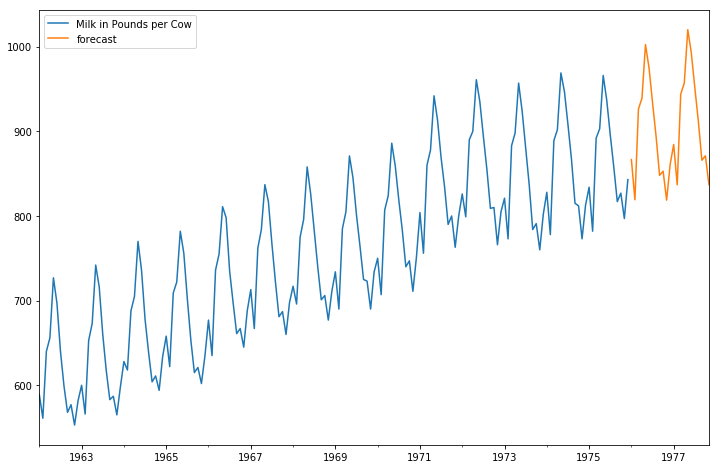

In [98]:
final_df[['Milk in Pounds per Cow','forecast']].plot(figsize=(12,8))